# Multi Agent Reinforcement Learning
In this notebook we create several reinforcement learning environments, based on *open AI*'s FrozenLake game:
- a single-agent frozen lake environment
- a multi-agent/ single goal environment
- a multi-agent/ 4 goals environment

In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import time
import random
import sys
import pygame
from collections import defaultdict
import os
import colorsys

from utils import run_simulation, visualizePolicyCommonGoal
from environments import MAPS, FrozenLakeOneGoal, createMap,FrozenLake4goals
from algorithms import SingleGoalCentralQLearning, RandomPolicy,IndependentQLearning,AlternatingIQL
import utils

## Single agent

## Multi agents
### Common goal

In [ ]:
def run_simulation(agent, map_, num_agent, num_episodes=10000, silent=True):
    # Create environment
    env = FrozenLakeOneGoal(map_=map_, max_steps=100, num_agents=num_agent)
    
    # Tracking metrics
    episode_rewards = []
    success_rate = []
    success_window = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        truncated = False
        step = 0
        
        # Run episode
        while not done and not truncated:
            # Select action
            action = agent.select_action(state)
            # Take action
            next_state, reward, done, truncated, _ = env.step(action)
            # Update Q-table
            agent.update(state, action, reward, next_state, done)
            # Update state and total reward
            state = next_state
            total_reward += reward
            step += 1
        
        # Record episode success/failure
        success = total_reward > 0.5
        success_window.append(success)
        if len(success_window) > 200:
            success_window.pop(0)
        
        # Calculate success rate over last 100 episodes
        current_success_rate = sum(success_window) / len(success_window)
        success_rate.append(current_success_rate)
        
        # Record total reward
        # mean_reward = total_reward / step if step > 0 else 0
        mean_reward = total_reward
        episode_rewards.append(mean_reward)
        
        # Print progress
        if not silent and episode % 100 == 0:
            print(f"Episode: {episode}, Total Reward: {mean_reward}, Success Rate: {current_success_rate:.2f}, Epsilon: {agent.epsilon:.4f}")
    
    window_size = 500
    mean_rewards_smooth = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    
    # Plot learning curve
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(mean_rewards_smooth)
    plt.axhline(y=1, color='black', linestyle='--', linewidth=2)
    plt.title('Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(success_rate)
    plt.title('Success Rate (500-episode moving average)')
    plt.xlabel('Episode')
    plt.ylabel('Success Rate')
    
    plt.tight_layout()
    plt.show()
    
    return agent

- **Visualizing the learned policy**

### 4 goals

In [2]:
n_agents=4
env_params={"num_agents":n_agents, 
                "grid_size":(8, 8), 
                "slip_prob":0., 
                "hole_prob":0.3, 
                "seed":25, 
                "collaboration_bonus":0,
                "collision_penalty":0}
env=FrozenLake4goals(**env_params)
env.render()

G H . . . . . G
. . . H . . H H
. H H H . H . .
. H . 2 . . . 4
. . . 1 . . . H
. H H 3 H . . .
H H H H . . H .
G . . . . H . G



In this environment there is 4 goals, the maximum reward is attained if all agents are evenly reparted:
- we add a collision penalty of 30 everytime 2 agents are on the same tile
- each goal is worth 100 at first and each time an agent reaches the reward the next reward is halved 

In [ ]:
env.reset()
iql_params = {
            "n_agents": n_agents,
            "learning_rate": 0.3,           # How quickly the agent incorporates new information (alpha)
            "discount_factor": 0.99,        # How much future rewards are valued (gamma)
            "exploration_rate": 1.0,        # Initial exploration rate (epsilon)
            "min_exploration_rate": 0.05,   # Minimum exploration rate
            "exploration_decay": 0.9999,     # How quickly exploration decreases
        }
##train params
max_episodes=100000   
max_steps=150

iql = IndependentQLearning(env,**iql_params)
results_iql = iql.train(episodes=max_episodes, max_steps=max_steps,verbose=True)
print("\nPolitiques indépendantes apprises:")
iql.render_policy()
# utils.save_agent(iql,'iql',env_info=env_params)




 11%|█         | 5336/50000 [00:04<00:32, 1380.82it/s]

Épisode 5000/50000, Récompenses moyennes agents: ['12.00', '13.50', '3.50', '20.00'], Epsilon: 0.6065


 20%|██        | 10158/50000 [00:07<00:29, 1369.13it/s]

Épisode 10000/50000, Récompenses moyennes agents: ['8.00', '26.00', '10.00', '44.00'], Epsilon: 0.3679


 30%|███       | 15206/50000 [00:11<00:31, 1116.24it/s]

Épisode 15000/50000, Récompenses moyennes agents: ['67.00', '65.50', '5.00', '71.00'], Epsilon: 0.2231


 40%|████      | 20122/50000 [00:18<00:50, 590.61it/s] 

Épisode 20000/50000, Récompenses moyennes agents: ['83.00', '78.00', '5.00', '80.00'], Epsilon: 0.1353


 50%|█████     | 25036/50000 [00:26<00:41, 601.73it/s]

Épisode 25000/50000, Récompenses moyennes agents: ['88.00', '86.00', '4.00', '94.00'], Epsilon: 0.0821


 60%|██████    | 30148/50000 [00:35<00:23, 829.30it/s]

Épisode 30000/50000, Récompenses moyennes agents: ['90.50', '94.00', '49.50', '95.00'], Epsilon: 0.0500


 70%|███████   | 35122/50000 [00:44<00:20, 714.21it/s]

Épisode 35000/50000, Récompenses moyennes agents: ['95.50', '97.00', '32.50', '94.00'], Epsilon: 0.0500


 80%|████████  | 40132/50000 [00:50<00:11, 837.12it/s] 

Épisode 40000/50000, Récompenses moyennes agents: ['62.00', '92.00', '55.50', '92.00'], Epsilon: 0.0500


 90%|█████████ | 45163/50000 [00:57<00:05, 836.08it/s]

Épisode 45000/50000, Récompenses moyennes agents: ['41.00', '86.00', '79.50', '94.00'], Epsilon: 0.0500


100%|██████████| 50000/50000 [01:04<00:00, 778.26it/s]

Épisode 50000/50000, Récompenses moyennes agents: ['84.50', '93.00', '39.50', '94.00'], Epsilon: 0.0500

Politiques indépendantes apprises:

Politique de l'agent 1:
 o  o  ↓  ←  ←  ↑  ←  o 
 ↑  ←  ←  o  →  ↑  o  o 
 ↑  o  o  o  ↓  o  →  ← 
 ↑  o  ↓  ↓  →  ←  ←  → 
 ↑  ←  ←  ←  ←  ←  ←  o 
 ←  o  o  ↑  o  ↑  ↑  ↓ 
 o  o  o  o  →  ←  o  ↑ 
 o  ←  o  o  ↑  o  o  o 

Politique de l'agent 2:
 o  o  ↓  →  →  →  →  o 
 ↓  ←  ←  o  →  ↑  o  o 
 ↑  o  o  o  ↑  o  ↓  ← 
 ↑  o  →  →  ↑  ←  ←  ← 
 ↑  ←  →  ↑  ↑  ←  ←  o 
 ↑  o  o  ↑  o  ↑  ↑  ← 
 o  o  o  o  →  ←  o  ↓ 
 o  o  o  o  ↑  o  o  o 

Politique de l'agent 3:
 o  o  ↓  ←  ←  ←  ←  o 
 ↑  ←  ←  o  →  ←  o  o 
 ↑  o  o  o  ↓  o  →  ← 
 ↑  o  →  ←  ←  ←  ↑  → 
 ↑  ←  ←  ←  ←  ←  ←  o 
 ↑  o  o  ↑  o  ↓  →  ↓ 
 o  o  o  o  o  ↑  o  ↑ 
 o  o  o  o  o  o  o  o 

Politique de l'agent 4:
 o  o  o  o  ↓  ↓  →  o 
 o  o  o  o  ↓  ←  o  o 
 o  o  o  o  ↓  o  ↓  ↓ 
 o  o  →  →  →  →  ↓  ← 
 o  →  →  →  →  ↓  ↓  o 
 o  o  o  ↑  o  →  →  ↓ 
 o  o  o  

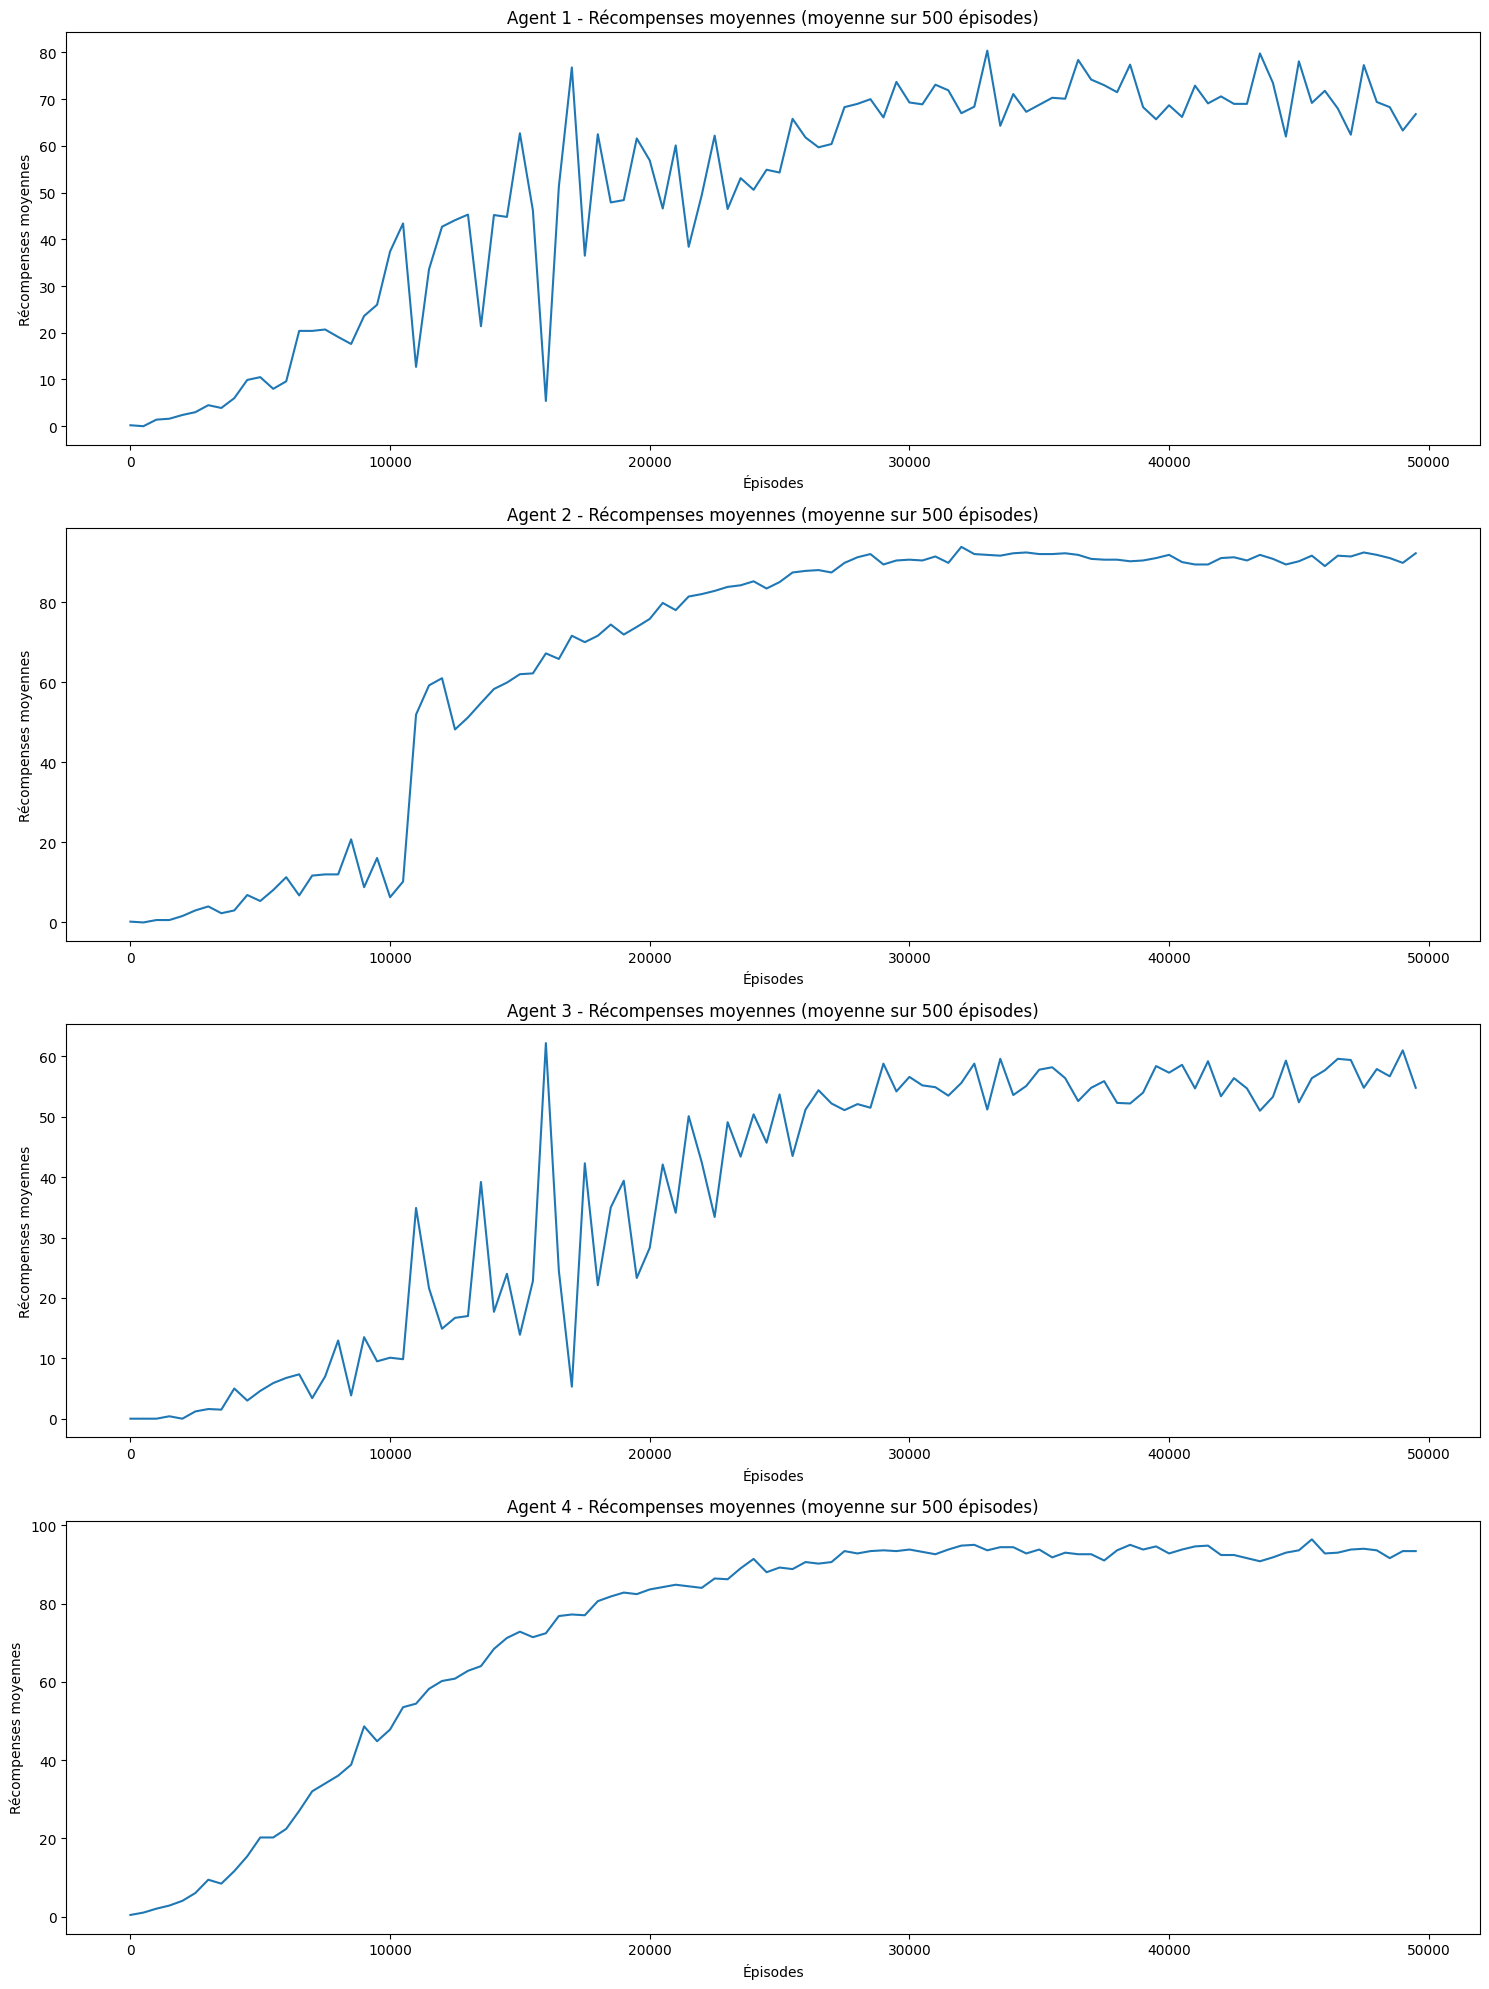

In [4]:
utils.plot_results(iql,results_iql,windows=500)

In [5]:
utils.visualize_policy_pygame_reusable(env,iql,20)


--- Début de la visualisation de la politique ---
État initial
Étape 1: Actions=['GAUCHE', 'DROITE', 'HAUT', 'GAUCHE'], Récompense=0, Total=0
Étape 2: Actions=['GAUCHE', 'HAUT', 'GAUCHE', 'BAS'], Récompense=0, Total=0
Étape 3: Actions=['GAUCHE', 'HAUT', 'GAUCHE', 'BAS'], Récompense=0, Total=0
Étape 4: Actions=['HAUT', 'DROITE', 'GAUCHE', 'DROITE'], Récompense=0, Total=0
Étape 5: Actions=['HAUT', 'HAUT', 'HAUT', 'BAS'], Récompense=0, Total=0
Étape 6: Agents {3} ont atteint un objectif!
Étape 6: Actions=['HAUT', 'DROITE', 'HAUT', 'BAS'], Récompense=100, Total=100
Étape 7: Agents {0, 1} ont atteint un objectif!
Étape 7: Actions=['HAUT', 'DROITE', 'HAUT', 'GAUCHE'], Récompense=200, Total=300
Étape 8: Agents {2} ont atteint un objectif!
Étape 8: Actions=['GAUCHE', 'GAUCHE', 'HAUT', 'GAUCHE'], Récompense=50.0, Total=350.0
Tous les agents ont terminé!

--- Fin de la visualisation ---
Total de 8 étapes
Récompense totale: 350.0
Objectifs atteints par les agents: {0, 1, 2, 3}


In [ ]:
env.reset()
alt_iql_params = {
            "n_agents": n_agents,
            "base_learning_rate": 0.4,           # How quickly the agent incorporates new information (alpha)
            "discount_factor": 0.99,        # How much future rewards are valued (gamma)
            "exploration_rate": 1.0,        # Initial exploration rate (epsilon)
            "min_exploration_rate": 0.05,   # Minimum exploration rate
            "exploration_decay": 0.9997,     # How quickly exploration decreases
            "alternating_period": 100, # number of episodes each agent learns before switching
            "learning_rate_ratio": 0.1, #the other agents lr=base_lr*ratio
        }
##train params
max_episodes=200000   
max_steps=200

alt_iql = AlternatingIQL(env,**alt_iql_params)
alt_iql_results = alt_iql.train(episodes=max_episodes, max_steps=max_steps,verbose=True)
print("\nPolitiques indépendantes apprises:")
alt_iql.render_policy()
# utils.save_agent(alt_iql,'alt_iql',env_info=env_params)

  0%|          | 0/100000 [00:00<?, ?it/s]

 10%|█         | 10038/100000 [00:22<07:12, 208.24it/s]

Épisode 10000/100000, Récompenses moyennes agents: ['86.50', '54.50', '0.50', '96.00'], Agent actif: 0, Taux d'apprentissage: ['0.4000', '0.0400', '0.0400', '0.0400']Epsilon: 0.050total _reward: 237.5000


 20%|██        | 20077/100000 [00:52<02:39, 501.67it/s]

Épisode 20000/100000, Récompenses moyennes agents: ['34.00', '73.00', '45.50', '94.00'], Agent actif: 0, Taux d'apprentissage: ['0.4000', '0.0400', '0.0400', '0.0400']Epsilon: 0.050total _reward: 246.5000


 25%|██▌       | 25191/100000 [01:09<05:51, 212.76it/s]

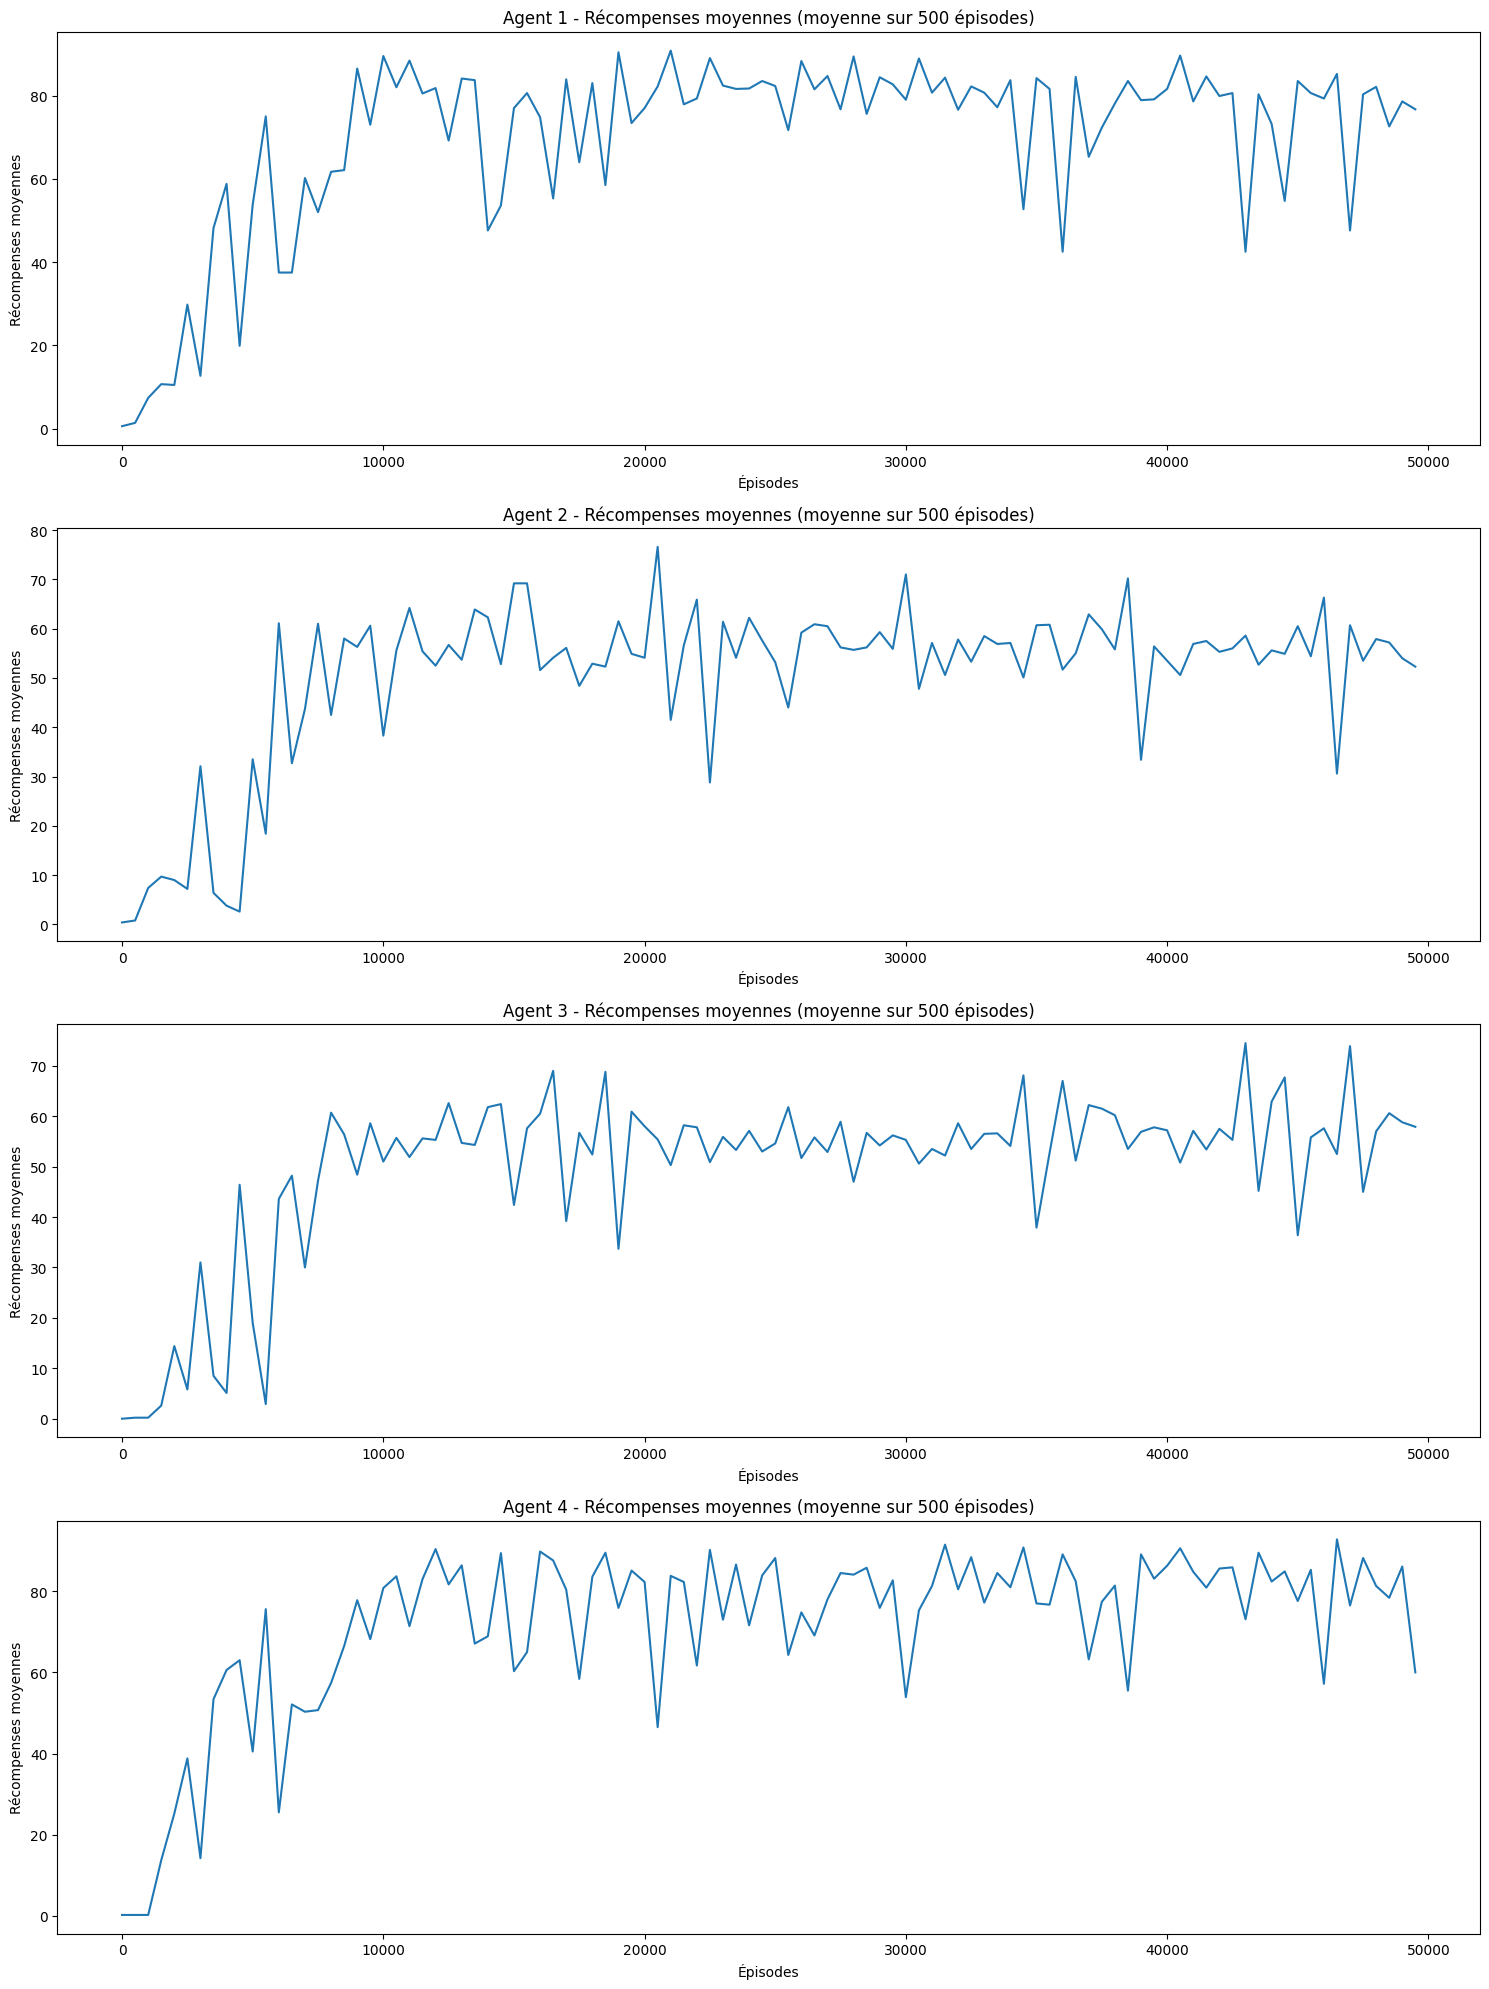

In [ ]:
utils.plot_results(alt_iql,alt_iql_results,windows=500)

In [ ]:
utils.visualize_policy_pygame_reusable(env,alt_iql,20)


--- Début de la visualisation de la politique ---
État initial
Étape 1: Actions=['DROITE', 'DROITE', 'HAUT', 'GAUCHE'], Récompense=0, Total=0
Étape 2: Actions=['DROITE', 'HAUT', 'GAUCHE', 'BAS'], Récompense=0, Total=0
Étape 3: Actions=['DROITE', 'HAUT', 'GAUCHE', 'BAS'], Récompense=0, Total=0
Étape 4: Actions=['BAS', 'DROITE', 'GAUCHE', 'DROITE'], Récompense=0, Total=0
Étape 5: Actions=['DROITE', 'HAUT', 'HAUT', 'BAS'], Récompense=0, Total=0
Étape 6: Actions=['BAS', 'DROITE', 'HAUT', 'DROITE'], Récompense=0, Total=0
⚠️ Collision entre les agents [0, 3]!
Étape 7: Agents {0, 1} ont atteint un objectif!
Étape 7: Actions=['BAS', 'DROITE', 'HAUT', 'DROITE'], Récompense=200, Total=200
Étape 8: Agents {2} ont atteint un objectif!
Étape 8: Actions=['GAUCHE', 'GAUCHE', 'HAUT', 'DROITE'], Récompense=100, Total=300
Étape 9: Actions=['GAUCHE', 'GAUCHE', 'GAUCHE', 'DROITE'], Récompense=0, Total=300
Étape 10: Actions=['GAUCHE', 'GAUCHE', 'GAUCHE', 'DROITE'], Récompense=0, Total=300
Étape 11: Action

: 